In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn2

from matplotlib.backends.backend_pdf import PdfPages
from upsetplot import UpSet, generate_counts
from matplotlib import cm
import geopandas as gpd

import sys
sys.path.append('../')
from src.plotting import *
from src.diversities import *

import pycodamath

In [2]:
## MATPLOTLIB SETTINGS FOR PLOTTING CONSISTENTLY
sns.set_context("paper")

# fontsizes
title_fontsize = 16
legend_fontsize = 14
axis_title_fontsize = 14
default_fontsize = 12

plt.rc('font', size=default_fontsize)
plt.rc('axes', titlesize=axis_title_fontsize)
plt.rc('axes', labelsize = axis_title_fontsize)
plt.rc('xtick', labelsize=default_fontsize)
plt.rc('ytick', labelsize=default_fontsize)
plt.rc('legend', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
plt.rc('figure', titlesize = title_fontsize)

# plot defaults
marker_size = 40

In [3]:
import os

# Set the directory of where dataframes are saved
data_dir = '../data/'

# Set the directory of where to save figures
fig_dir = '../fig/db_comparisons_reviewer3'
os.makedirs(fig_dir, exist_ok=True)

In [4]:
db2db = {
    'amrfinderplus': 'AMRFinderPlus',
    'argannot': 'ARGANNOT',
    'card_amr': 'CARD',
    'functional_amr': 'ResFinderFG',
    'megares' : 'MegaRes',
    'resfinder': 'ResFinder',
    'csabapal': 'CsabaPal',
    'metalres': 'MetalRes'
}

db2group = {
    'ResFinder': 'Acquired',
    'ResFinderFG': 'FG',
    'CsabaPal': 'FG',
    'AMRFinderPlus': 'Other ARGs',
    'ARGANNOT': 'Other ARGs',
    'CARD': 'Other ARGs',
    'MegaRes': 'Other ARGs'
}
group2db = {v: [k for k, val in db2group.items() if val == v] for v in set(db2group.values())}


In [5]:
# Metadata for ARGs
sel_genesClusters_all = pd.read_csv('../data/csv_files/panres_metadata_fixed.csv')
sel_genesClusters_all['db'] = sel_genesClusters_all['database'].map(db2db).fillna(sel_genesClusters_all['database'])

# drop metal and biocides
sel_genesClusters = sel_genesClusters_all.dropna(subset=['class'], axis='rows')
sel_genesClusters['class'] = sel_genesClusters['class'].apply(eval)
sel_genesClusters = sel_genesClusters.loc[sel_genesClusters['database'].isin(db2db.keys())]
sel_genesClusters['db_group'] = sel_genesClusters['db'].map(db2group).fillna('Other ARGs')

/tmp/ipykernel_460129/2797122414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_genesClusters['class'] = sel_genesClusters['class'].apply(eval)


In [6]:
palettes, palette_handles = make_palette(
    labels = ['Acquired', 'FG', 'AMRFinderPlus', 'ARG-ANNOT', 'CARD', 'MegaRes', 'Other ARGs', 'Genera'],
    colors = ['#FC766AFF', '#5B84B1FF', '#04e762', '#f5b700', '#dc0073', '#008bf8', '#4c956c', '#1f77b4']
)

In [7]:
palettes

{'Acquired': '#FC766AFF',
 'FG': '#5B84B1FF',
 'AMRFinderPlus': '#04e762',
 'ARG-ANNOT': '#f5b700',
 'CARD': '#dc0073',
 'MegaRes': '#008bf8',
 'Other ARGs': '#4c956c',
 'Genera': '#1f77b4'}

In [8]:
group2cluster = {}
cluster2group = {}
already_seen = set()
for k, v in sel_genesClusters.groupby('db_group').agg({'cluster_representative_98': lambda x: set(x)}).iterrows():
    ss = v['cluster_representative_98']

    group2cluster[k] = ss.difference(already_seen)
    already_seen = already_seen.union(ss)
    print(k, type(ss), len(group2cluster[k]))

    for uc in group2cluster[k]:
        cluster2group[uc] = k

Acquired <class 'set'> 1119
FG <class 'set'> 3421
Other ARGs <class 'set'> 1672


# Database overlaps

In [9]:
sel_genesClusters_all.groupby(['db']).agg({'gene': 'nunique'})

,gene
db,
AMRFinderPlus,6465
ARGANNOT,2223
CARD,4661
CsabaPal,1093
MegaRes,8295
MetalRes,578
ResFinder,3131
ResFinderFG,3897


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

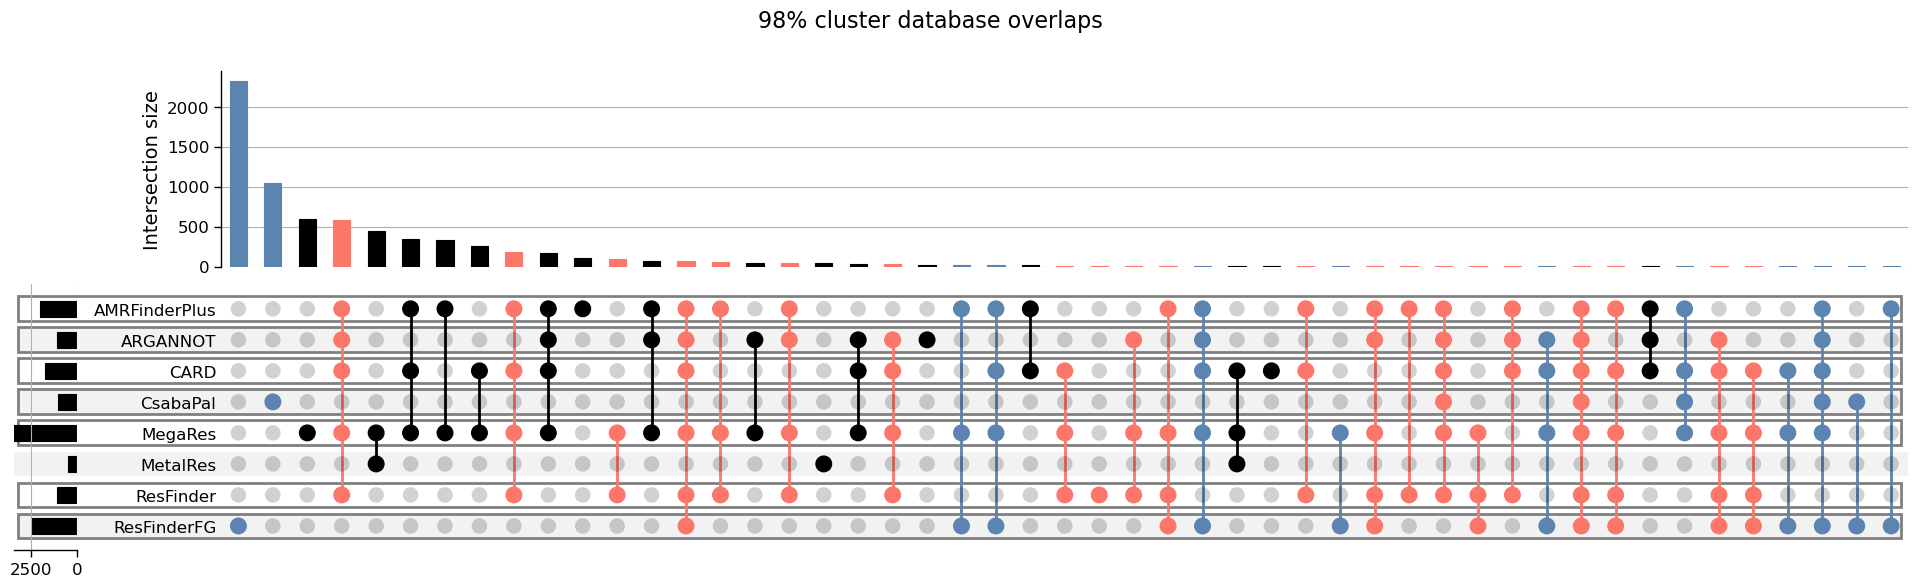

In [10]:
def make_upsetplot(df, highlights, palette, subset_styles=[], groupby='db', col = 'cluster_representative_98', names_fix={}, **kwargs):
    all_sets_dict = df.groupby(groupby).agg({col: set})[col].to_dict()
    all_elements = df[col].unique().tolist()

    set_names = list(all_sets_dict.keys())
    set_names = [names_fix.get(s, s) for s in set_names]
    
    all_sets = list(all_sets_dict.values())

    all_df = pd.DataFrame([[e in st for st in all_sets] for e in all_elements], columns=set_names)
    all_df_up = all_df.groupby(sorted(set_names)).size()

    p = UpSet(
        all_df_up, 
        show_counts=kwargs.get('show_counts', False),
        sort_by = kwargs.get('sort_by', 'cardinality'),
        sort_categories_by = kwargs.get('sort_categories_by', '-input')
    )

    # highlight groups of interest (db2group)
    p.style_categories(highlights, shading_edgecolor=kwargs.get('edgecolor', 'grey'), shading_linewidth = kwargs.get('lw', 2))
    
    for style in subset_styles:
        p.style_subsets(**style)

    fig = p.plot()
    plt.suptitle(kwargs.get('title', ''))

    # add stacked_bars ? 
    if kwargs.get('stacked_bars', False):
        p.add_stacked_bars(
            by=kwargs.get('bars_by', 'class'), 
            colors = kwargs.get('cm_bar', 'twilight_shifted_r'),
            elements = kwargs.get('bar_elements', 3)
        )

    
    return fig

make_upsetplot(
    df= sel_genesClusters_all,
    palette = palettes,
    groupby='db',
    col = 'cluster_representative_98',
    names_fix = {'metalres': 'MetalRes'},
    highlights = list(db2group.keys()),
    subset_styles = [
        {'present': 'ResFinder', 'absent': [], 'facecolor': palettes['Acquired']},
        {'present': 'ResFinderFG', 'absent': ['ResFinder'], 'facecolor': palettes['FG']},
        {'present': 'CsabaPal', 'absent': ['ResFinder'], 'facecolor': palettes['FG']},
    ],
    title = '98% cluster database overlaps'
)
plt.savefig(os.path.join(fig_dir, 'overlap_databases_upset.png'), bbox_inches='tight')

## between acquired/FG/Others

In [11]:
sel_genesClusters['db_group2'] = sel_genesClusters['db'].map(db2group).fillna(sel_genesClusters['db'])

/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

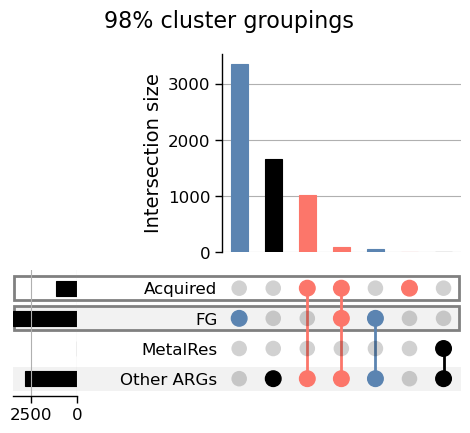

In [12]:
make_upsetplot(
    df= sel_genesClusters,
    palette = palettes,
    groupby='db_group2',
    col = 'cluster_representative_98',
    names_fix = {'metalres': 'MetalRes'},
    highlights = ['Acquired', 'FG'],
    subset_styles = [
        {'present': 'Acquired', 'absent': [], 'facecolor': palettes['Acquired']},
        {'present': 'FG', 'absent': ['Acquired'], 'facecolor': palettes['FG']}    ],
    title = '98% cluster groupings'
)
plt.savefig(os.path.join(fig_dir, 'overlap_group_upset.png'), bbox_inches='tight')

### what are the genes we have not included in our manuscript ?

In [13]:
acquired_clusters = set(sel_genesClusters.loc[sel_genesClusters['db_group'] == 'Acquired', 'cluster_representative_98'].unique())
fg_clusters = set(sel_genesClusters.loc[sel_genesClusters['db_group'] == 'FG', 'cluster_representative_98'].unique()).difference(acquired_clusters)
other_clusters = set(sel_genesClusters.loc[sel_genesClusters['db_group'] == 'Other ARGs', 'cluster_representative_98'].unique()).difference(acquired_clusters).difference(fg_clusters)

for k, s in zip(['Acquired', 'FG', 'Other ARGs'], [acquired_clusters, fg_clusters, other_clusters]):
    print(f"{k}: {len(s)}")

Acquired: 1119
FG: 3421
Other ARGs: 1672


In [14]:
other_geneClusters = sel_genesClusters.loc[
sel_genesClusters.cluster_representative_98.isin(other_clusters), ['cluster_representative_98', 'class', 'db', 'db_group', 'fa_name']
].explode('class')
other_geneClusters

,cluster_representative_98,class,db,db_group,fa_name
849,pan_10537,beta_lactam,AMRFinderPlus,Other ARGs,amrfinderplus|2165384393|wp_231869655.1|ng_078...
858,pan_10541,beta_lactam,AMRFinderPlus,Other ARGs,amrfinderplus|2165384348|wp_231869610.1|ng_078...
865,pan_5600,beta_lactam,AMRFinderPlus,Other ARGs,amrfinderplus|2214661677|wp_242934116.1|ng_079...
876,pan_10554,beta_lactam,AMRFinderPlus,Other ARGs,amrfinderplus|1883867327|wp_181483194.1|ng_081...
879,pan_10557,beta_lactam,AMRFinderPlus,Other ARGs,amrfinderplus|1887756518|wp_182237112.1|ng_088...
...,...,...,...,...,...
30345,pan_9960,aminoglycoside,MegaRes,Other ARGs,megares|meg_357|drugs|aminoglycosides|aminogly...
30346,pan_8458,aminoglycoside,MegaRes,Other ARGs,megares|meg_347|drugs|aminoglycosides|aminogly...
30347,pan_9962,aminoglycoside,MegaRes,Other ARGs,megares|meg_47|drugs|aminoglycosides|aminoglyc...
30349,pan_9964,aminoglycoside,MegaRes,Other ARGs,megares|meg_336|drugs|aminoglycosides|aminogly...


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

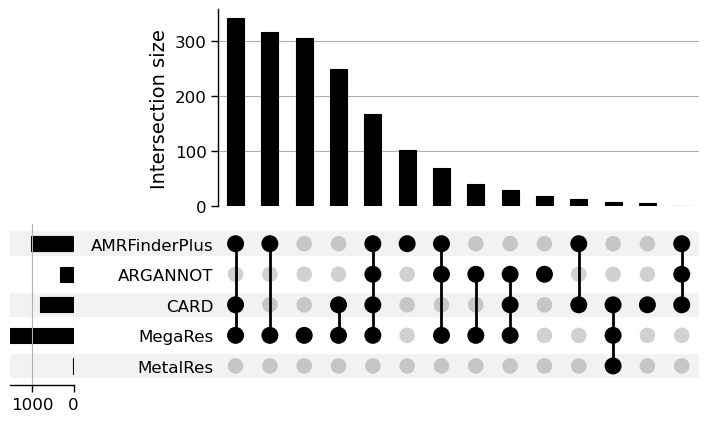

In [15]:
make_upsetplot(
    df= other_geneClusters,
    palette = palettes,
    groupby='db',
    col = 'cluster_representative_98',
    names_fix = {'metalres': 'MetalRes'},
    highlights = [],
    #subset_styles = [
    #    {'present': 'Acquired', 'absent': [], 'facecolor': palettes['Acquired']},
    #    {'present': 'FG', 'absent': ['Acquired'], 'facecolor': palettes['FG']}    ],
    #title = '98% cluster groupings'
)
plt.savefig(os.path.join(fig_dir, 'overlap_groupings_upset.png'), bbox_inches='tight')

### venn diagram showing overlap

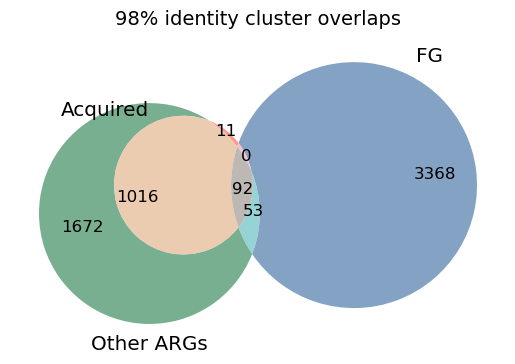

In [16]:
all_overlap_sets = sel_genesClusters.groupby(
    'db_group'
).agg(
    {'cluster_representative_98': lambda x: set(sorted(x))}
)
venn3(
    all_overlap_sets.cluster_representative_98.tolist(),
    set_labels = all_overlap_sets.index.tolist(),
    set_colors = [palettes[i] for i in all_overlap_sets.index.tolist()],
    alpha = .75
)
plt.title("98% identity cluster overlaps")
plt.savefig(os.path.join(fig_dir, 'overlap_groupings_venn.png'), bbox_inches='tight')

/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

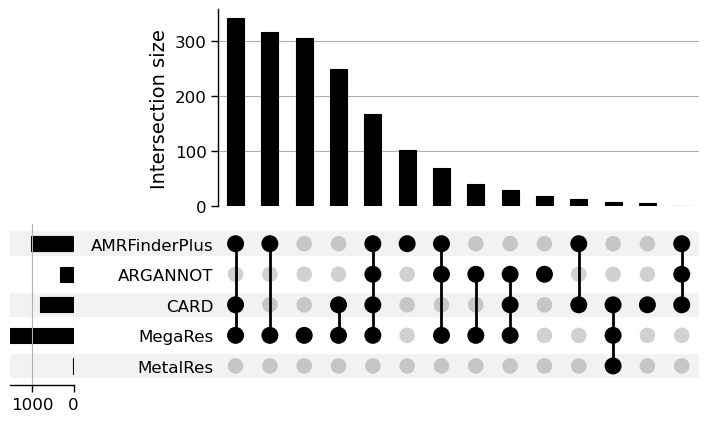

In [17]:
make_upsetplot(
    df= other_geneClusters,
    palette = palettes,
    groupby='db',
    col = 'cluster_representative_98',
    names_fix = {'metalres': 'MetalRes'},
    highlights = [],
    #subset_styles = [
    #    {'present': 'Acquired', 'absent': [], 'facecolor': palettes['Acquired']},
    #    {'present': 'FG', 'absent': ['Acquired'], 'facecolor': palettes['FG']}    ],
    #title = '98% cluster groupings'
)
plt.savefig(os.path.join(fig_dir, 'overlap_groupings_upset.png'), bbox_inches='tight')

In [18]:
def get_gene_name(row):

    fa_name = row['fa_name'].split('|')
    if row['db'] == 'AMRFinderPlus':
        return fa_name[6]
    elif row['db'] == 'ARG-ANNOT':
        return ")".join(fa_name[1].split(')')[1:])
    elif row['db'] == 'CARD':
        return fa_name[6].split(' [')[0]
    elif row['db'] == 'MegaRes':
        return fa_name[5]

other_geneClusters['cluster_gene_name'] = other_geneClusters.apply(get_gene_name, axis = 1)
other_geneClusters['pan_gene_name'] = other_geneClusters.apply(lambda x: f"{x['cluster_representative_98']} ({x['cluster_gene_name']})", axis = 1)

/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

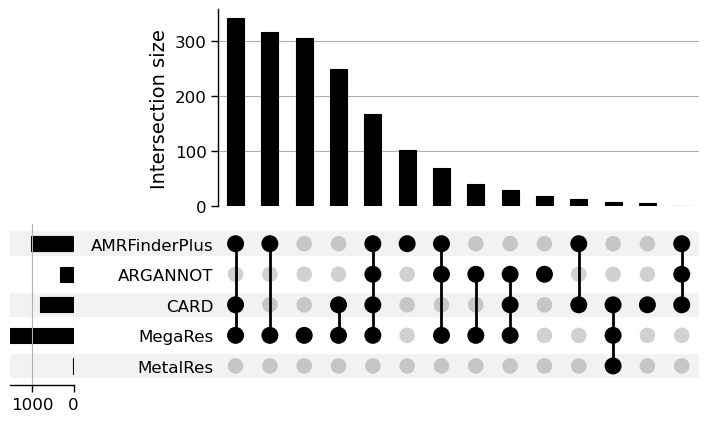

In [19]:
other_geneClusters2 = other_geneClusters.merge(
    pd.DataFrame(
        other_geneClusters.groupby(['cluster_representative_98']).agg({'class': 'unique'}).apply(lambda x: x['class'][0].title() if len(x['class']) == 1 else 'MDR',
            axis = 1
        ), 
        columns = ['class2']
    ),
    left_on='cluster_representative_98',
    right_index=True,
    how = 'left'
)
make_upsetplot(
    df= other_geneClusters2,
    palette = palettes,
    groupby='db',
    col = 'cluster_representative_98',
    names_fix = {'metalres': 'MetalRes'},
    highlights = [],
    stacked_bars = True
    #subset_styles = [
    #    {'present': 'Acquired', 'absent': [], 'facecolor': palettes['Acquired']},
    #    {'present': 'FG', 'absent': ['Acquired'], 'facecolor': palettes['FG']}    ],
    #title = '98% cluster groupings'
)

# Metadata

In [20]:
metadata = pd.read_csv(os.path.join(data_dir, 'csv_files', 'metadata_fixed.csv'), index_col=0).drop_duplicates(subset=['genepid', 'complete_name'])
geo_data = gpd.read_parquet(os.path.join(data_dir, 'gs3.parquet'))
countries =  gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

country2country = {
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Czech Republic': 'Czechia',
    "Ivory Coast": "Côte d'Ivoire",
    'Democratic Republic of the Congo': 'Dem. Rep. Congo',
    'Macedonia': 'North Macedonia' ,
    'United States': 'United States of America',
    
    
}
geo_data['country'] = geo_data['country'].replace(country2country)
countries['name'] = countries['name'].replace(country2country)

geoCitys = pd.DataFrame(metadata.groupby(['country', 'city']).genepid.nunique()).merge(geo_data[['country', 'city', 'gps_geometry']], on = ['country', 'city'], how='left')
geoCountries = pd.DataFrame(metadata.groupby(['country']).genepid.nunique()).merge(geo_data[['country', 'country_geometry']], on = ['country'], how='left')


/tmp/ipykernel_460129/3232385749.py:2: UserWarning: Multiple non-primary geometry columns read from Parquet/Feather file. The first column read was promoted to the primary geometry.
  geo_data = gpd.read_parquet(os.path.join(data_dir, 'gs3.parquet'))
/tmp/ipykernel_460129/3232385749.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries =  gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


# Counts

## Genus

In [21]:
# Load in the genus counts
counts_genus = pd.read_csv('../motus_counts/motus_agg_pad/genus_motus_pad_agg_counts.csv')

# Get those taxa that are bacterial
genus_tax = pd.read_csv('../motus_counts/motus_agg_pad/genus_motus_pad_agg_taxa_paths.csv')
bacterial_taxa = genus_tax.loc[genus_tax['path_taxs'].str.startswith('2;'), 'name'].values.tolist()


counts_genus = counts_genus.merge(
    metadata[['genepid', 'city', 'country', 'Region']].drop_duplicates(), on='genepid', how='left'
).set_index(['genepid', 'city', 'country', 'Region'])

counts_genus = counts_genus.iloc[:, counts_genus.columns.isin(bacterial_taxa)]

## ARGs

In [22]:
hdf_file = os.path.join(data_dir, "gs3_v2.h5")
tot_counts = pd.read_hdf(hdf_file, 'tot_counts')


In [23]:
counts = pd.read_csv('../data/counts_clusters_dbs.csv')
counts.columns = [db2db.get(c, c) for c in counts.columns]

In [24]:
counts['group'] = counts['cluster_representative_98'].map(cluster2group)

In [25]:
count_groups = counts.groupby(['group', 'genepid', 'cluster_representative_98']).agg(
    {k: 'sum' for k in ['fragmentCountAln', 'fragmentCountAln_adj', 'fragmentCountAln_adj_kb']}
)

### summary

In [26]:
count_groups.reset_index().groupby('group').agg(
    {
        'cluster_representative_98': 'nunique', 
        'fragmentCountAln': 'sum'
    }
)

,cluster_representative_98,fragmentCountAln
group,,
Acquired,1052,17283116
FG,3095,21748240
Other ARGs,1498,31016194


In [27]:
def describe_counts(df, column='fragmentCountAln', rename=''):

    df_desc = df[column].describe()
    df_sum = pd.Series(df[column].sum(), index=['sum'])

    if len(rename) > 0 : column = rename
    result = pd.DataFrame(pd.concat([df_desc, df_sum], axis=0), columns=[column])
    return result

In [28]:
describe_counts(count_groups.groupby('genepid').agg({'fragmentCountAln': 'sum'})) * 10**(-6)

,fragmentCountAln
count,0.001147
mean,0.061070
std,0.042875
min,0.002588
25%,0.037015
50%,0.050486
75%,0.072457
max,0.438551
sum,70.047550


In [29]:
count_groups.groupby('group').apply(
    lambda x: describe_counts(x.groupby('genepid').agg({'fragmentCountAln': 'sum'}))
) * 10**(-6)

fragmentCountAln
group                             
Acquired   count          0.001147
           mean           0.015068
           std            0.013101
           min            0.000214
           25%            0.007445
           50%            0.011850
           75%            0.018259
           max            0.113346
           sum           17.283116
FG         count          0.001147
           mean           0.018961
           std            0.015987
           min            0.000612
           25%            0.010400
           50%            0.015641
           75%            0.022929
           max            0.238623
           sum           21.748240
Other ARGs count          0.001147
           mean           0.027041
           std            0.018937
           min            0.001155
           25%            0.016661
           50%            0.022810
           75%            0.031415
           max            0.208777
           sum           31.016194

### alpha diversities

In [30]:
def alpha_diversities(data):
    

    data2 = data.reset_index().rename(columns ={'cluster_representative_98': 'gene'})
    data2 = data2.replace([-np.inf, np.inf], np.nan)
    richness = estimate_richness(
        data2,
        groupby='genepid'
    )

    shannon = estimate_shannon(data2, groupby=['genepid', 'gene'])

    results = pd.concat(
        [richness, shannon], axis = 1
    ).rename(
        columns={
            'fragmentCountAln_adj': 'total_frags',
            'n_references': 'richness'
        }
    )
    return results

In [31]:
genus_alpha = alpha_diversities(
    counts_genus.melt(ignore_index=False, var_name='cluster_representative_98', value_name='fragmentCountAln_adj')
)

In [32]:
arg_alpha = count_groups.groupby('group').apply(alpha_diversities)

In [33]:
df_alpha = arg_alpha.merge(genus_alpha, left_index=True, right_index=True, suffixes=['_arg', '_bac'])
df_alpha = df_alpha.reset_index(level=0)

In [34]:
import scipy.stats as ss
def annotate(data, **kws):
    r, p = ss.pearsonr(data[kws['x']], data[kws['y']])
    ax = kws.get('ax', plt.gca())

    x = 0.05 + kws.get('x_scatter', 0)
    y = 0.8 + kws.get('y_scatter', 0)
    ax.text(x, y, '{} r={:.2f}, p={:.2g}'.format(kws.get('label', ''), r, p), transform=ax.transAxes)


In [35]:
df_alpha.head()

,group,richness_arg,total_frags_arg,shannon_arg,richness_bac,total_frags_bac,shannon_bac
genepid,,,,,,,
1011236.0,Acquired,212,10.063710,3.550758,945,59738.874499,3.788452
1011237.0,Acquired,250,9.560369,3.691932,1043,62554.764880,3.882467
1011238.0,Acquired,218,6.290360,3.959093,1148,67739.439651,4.157961
1011239.0,Acquired,270,15.815236,3.980143,1113,71546.599319,4.132696
1011240.0,Acquired,246,12.090220,4.038124,1063,72369.494567,4.213556


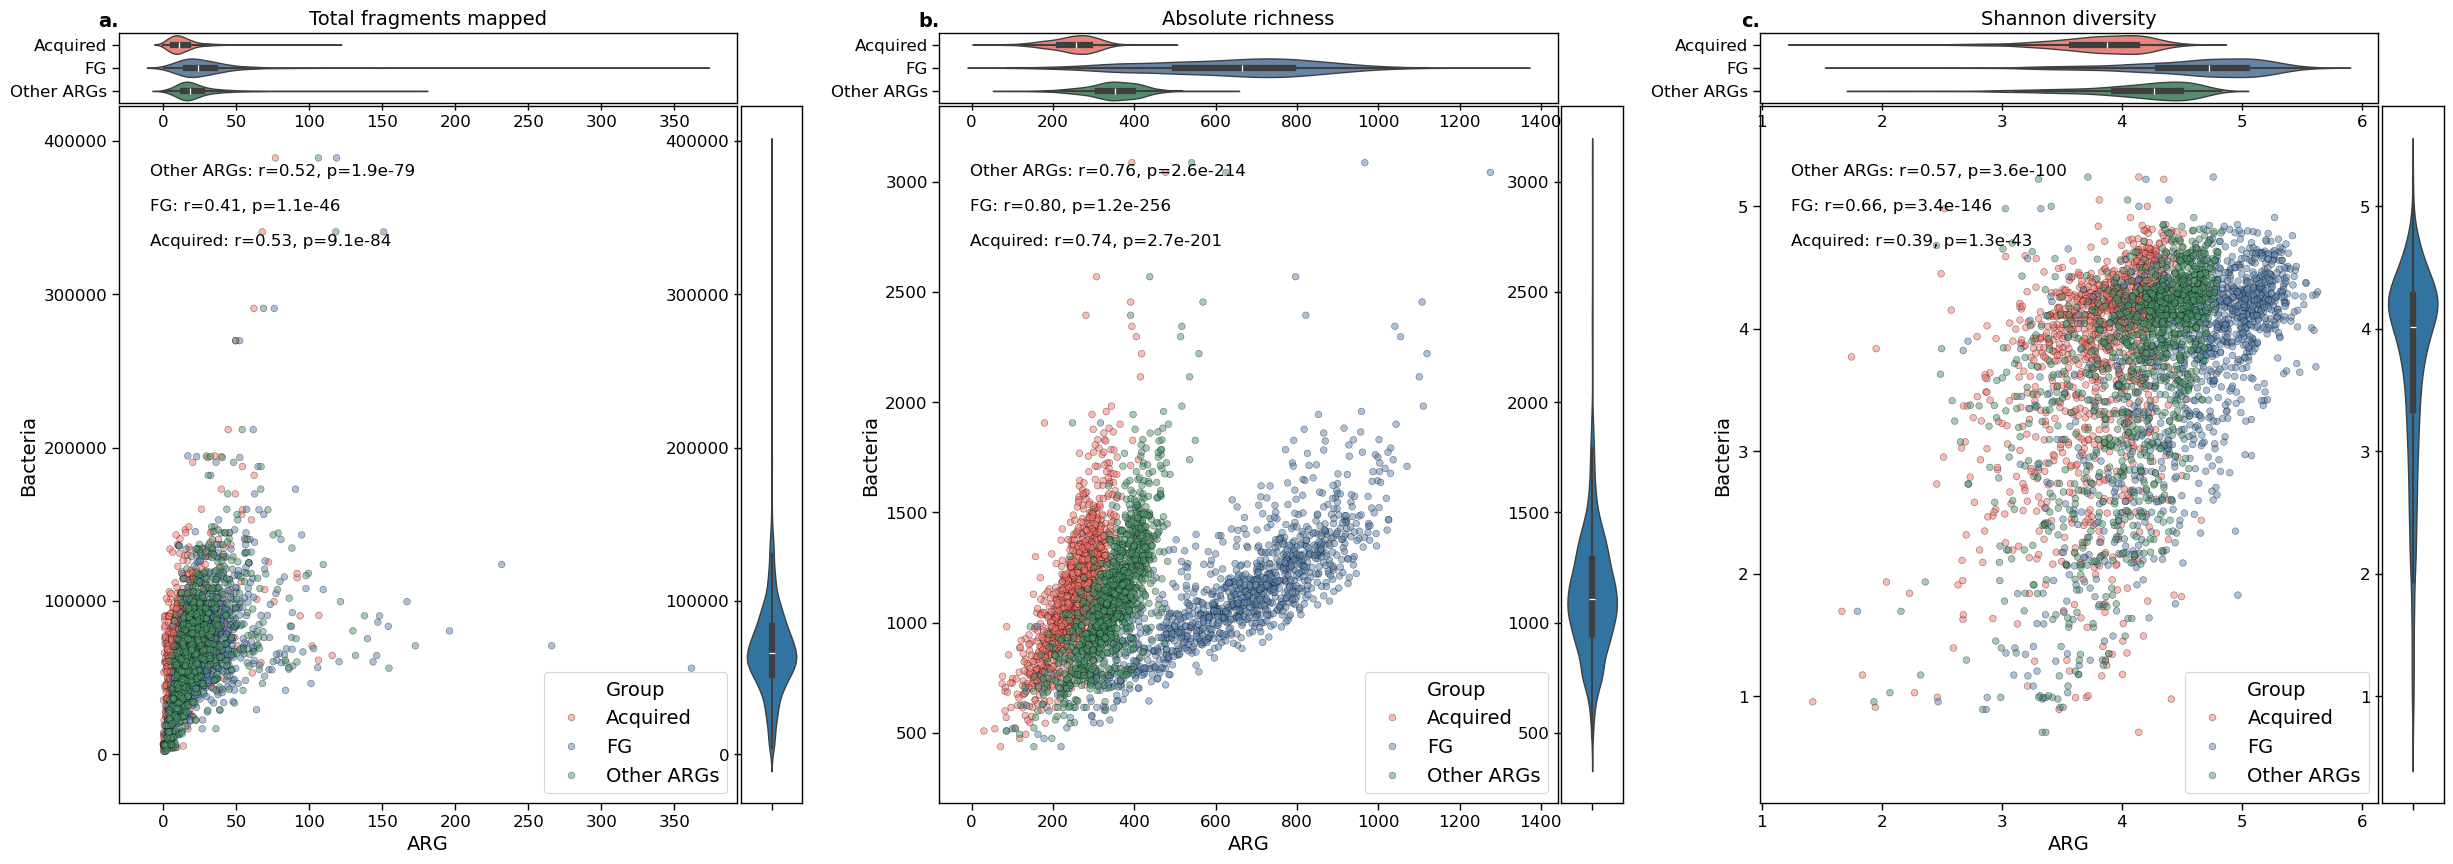

In [36]:
fig = plt.figure(figsize=(30,10))
gs = gridspec.GridSpec(ncols=3, nrows=1)

alpha_measures = ['total_frags', 'richness', 'shannon']

for i, (metric, title) in enumerate(zip(alpha_measures, ['Total fragments mapped', 'Absolute richness', 'Shannon diversity'])):
    gs_sub = gridspec.GridSpecFromSubplotSpec(
        ncols = 2, nrows = 2,
        width_ratios = [1, .1],
        height_ratios = [.1, 1],
        hspace = 0.01, wspace = 0.01,
        subplot_spec = gs[i]
    )

    ax_main = fig.add_subplot(gs_sub[1,0])
    ax_top = fig.add_subplot(gs_sub[0,0], sharex=ax_main)
    ax_right = fig.add_subplot(gs_sub[1,1], sharey=ax_main)

    ax_top.set_title(title)

    sns.violinplot(
        data = df_alpha,
        x = metric + '_arg',
        y = 'group',
        hue = 'group', 
        hue_order = ['Acquired', 'FG', 'Other ARGs'],
        palette = palettes,
        ax = ax_top
    )

    sns.violinplot(
        data = df_alpha,
        y = metric + '_bac',
        ax = ax_right,
        color = palettes['Genera']
    )

    sns.scatterplot(
        data = df_alpha,
        x = metric + '_arg',
        y = metric + '_bac',
        hue = 'group',
        hue_order = ['Acquired', 'FG', 'Other ARGs'],
        palette = palettes,
        alpha = .5,
        edgecolor='black',
        ax = ax_main
    )

    ax_top.set_xlabel('')
    ax_top.set_ylabel('')
    ax_right.set_xlabel('')
    ax_right.set_ylabel('')

    ax_main.set_xlabel('ARG')
    ax_main.set_ylabel('Bacteria')

    ax_main.legend(loc='lower right', title='Group')

    for g, scat in zip(['Acquired', 'FG', 'Other ARGs'], [0, 0.05, 0.1]):
        annotate(
            df_alpha.loc[df_alpha['group'] == g, ].dropna(),
            ax = ax_main,
            x = metric + '_arg',
            y = metric + '_bac',
            label = g + ':',
            y_scatter = scat 
        )

    ax_top.text(-0.0, 1.3, alphabet[i] + '.', transform=ax_top.transAxes, fontsize=axis_title_fontsize, va='top', ha='right', fontweight='bold')


plt.savefig(os.path.join(fig_dir, 'groups_diversities.png'), bbox_inches='tight')

### ALR abundances

In [37]:
# only retain genera that makes up more than 0.0001% of all mOTU reads
# for ALR and beta-diversity
genus_retained = pd.DataFrame((counts_genus.replace([np.inf], np.nan).sum() / counts_genus.replace([np.inf], np.nan).sum().sum())*100, columns=['pct']).query("pct >= 0.0001").index
counts_genus_reduced = counts_genus[genus_retained]

In [38]:
sampleSums = count_groups.groupby(['group', 'genepid']).agg({'fragmentCountAln_adj_kb': 'sum'}).reset_index().merge(
    counts_genus_reduced.drop_duplicates().sum(1).reset_index().rename(columns={0:'fragmentCountAln_bac'}),
    on='genepid',
    how='left'
)
sampleSums['fragmentCountAln_bac'] /= 1e6
countryALRs = sampleSums.groupby(['country', 'group']).agg(
    {'fragmentCountAln_bac': 'sum', 'fragmentCountAln_adj_kb': 'sum'}
).apply(lambda x: np.log10(x['fragmentCountAln_adj_kb'] / x['fragmentCountAln_bac']), axis=1)
countryALRs = pd.DataFrame(countryALRs, columns=['ALR'])
countryALRs = countryALRs.reset_index().merge(
    geo_data[['country', 'country_geometry']].drop_duplicates().replace(
        {
            'United States': 'United States of America',
            'Bosnia and Herzegovina': 'Bosnia and Herz.',
            'Democratic Republic of the Congo': 'Dem. Rep. Congo',
            'Czech Republic': 'Czechia',
            'Ivory Coast' :"Côte d'Ivoire",
            'Macedonia': 'North Macedonia',
            
        }
    ), 
    on='country', how='left'
).drop_duplicates()

countryALRs.loc[
    countryALRs.country == 'Malaysia', 'country_geometry'
] = geo_data.query("country == 'Malaysia'")["country_geometry"].drop_duplicates().dropna().item()

countryALRs = gpd.GeoDataFrame(countryALRs, geometry='country_geometry')

/tmp/ipykernel_460129/3829394603.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


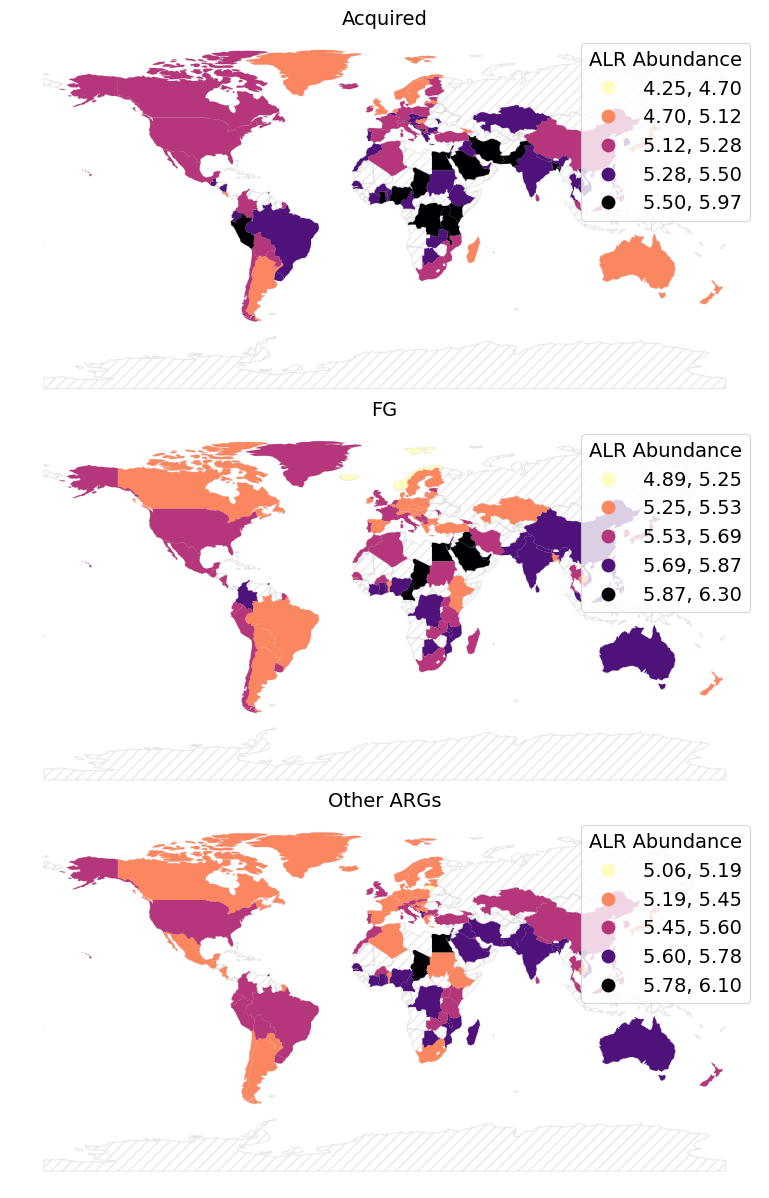

In [39]:
alr_vmin = countryALRs['ALR'].min()
alr_vmax = countryALRs['ALR'].max()

cmap = 'magma_r'

dim = 10
scale = 1.5

nrows = 3
ncols = 1

fig = plt.figure(figsize=(dim*nrows, dim*ncols*scale))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, wspace=0.05, hspace=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=alr_vmin, vmax=alr_vmax))
cbar_label = 'ALR Abundance'

for i, (g) in enumerate(['Acquired', 'FG', 'Other ARGs']):
    ax_map = fig.add_subplot(gs[i])
    ax_map.set_title(g)
    countries.plot(color='white', edgecolor='lightgray', hatch='///', alpha = .5, ax=ax_map)

    countryALRs.loc[
        countryALRs.group == g
    ].plot(
        column='ALR',
        cmap = cmap,
        scheme="natural_breaks",
        legend=True,
        legend_kwds={
            'title': cbar_label
        },
        ax = ax_map,
        k = 5
    )
        
    ax_map.axis('off')

fig.tight_layout()
plt.savefig(os.path.join(fig_dir, 'groups_alr_map.png'), bbox_inches='tight')

#### Regional + PCA

In [40]:
def pivot_counts(data, idx = 'genepid', col='cluster_representative_98', val='fragmentCountAln_adj'):
    df = data.pivot_table(
        index = idx,
        columns = col,
        values = val,
        aggfunc='sum',
        fill_value = 0
    )
    return df

In [41]:
regionAbbrs = {
    'East Asia & Pacific': 'EAP',
    'Europe & Central Asia': 'ECA',
    'Latin America & Caribbean': 'LAC',
    'Middle East & North Africa': 'MENA',
    'North America': 'NA',
    'Sub-Saharan Africa': 'SSA',
    'South Asia': 'SA'
}
countryALRRegions = countryALRs.merge(metadata[['country', 'Region']].drop_duplicates(), on='country')

In [42]:
scoresDict = {}

/tmp/ipykernel_460129/3057627448.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  widths[np.where(widths < min_width)[0]] = min_width


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


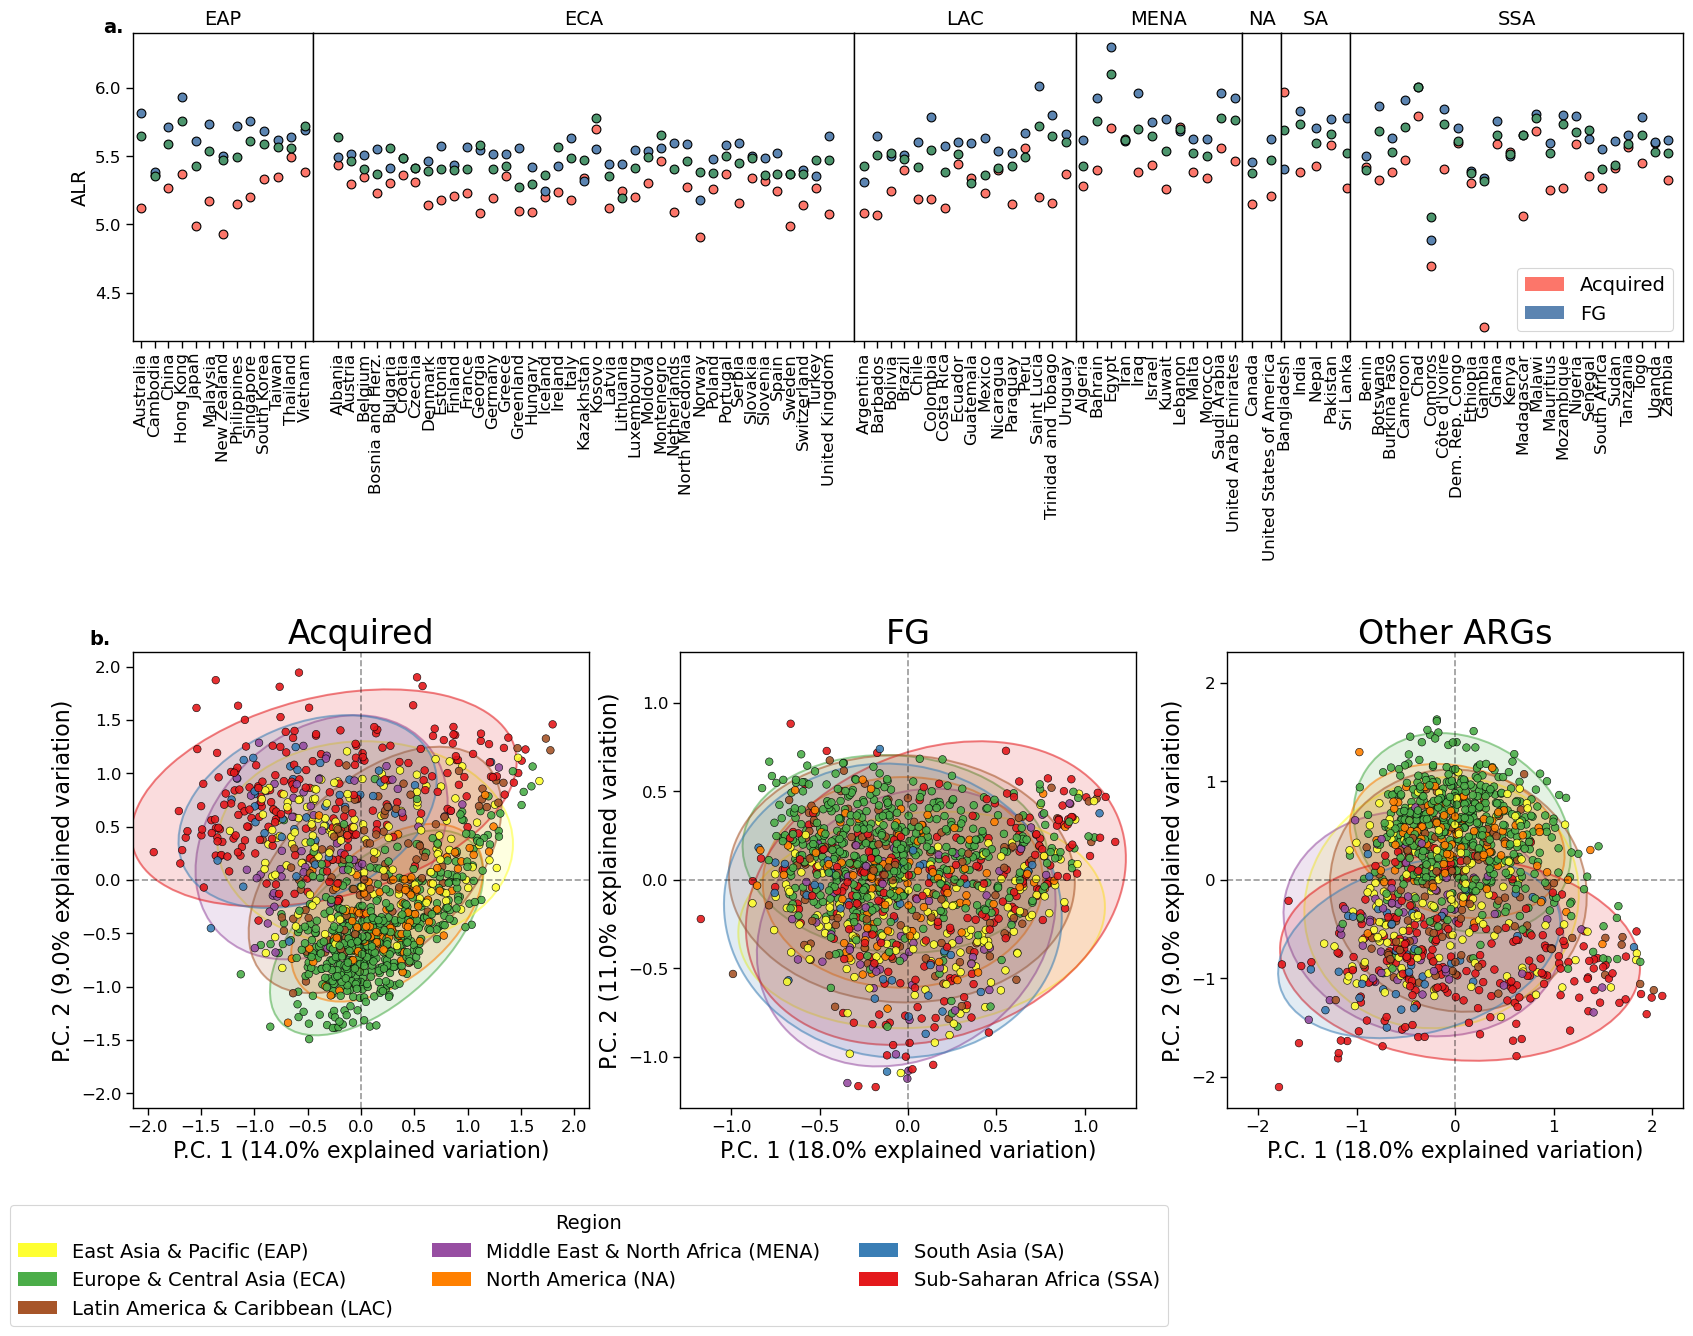

In [43]:
widths = metadata[['Region', 'country']].drop_duplicates().groupby('Region').agg({'country': 'nunique'})['country']
widths /= widths.sum()
min_width = 0.025
widths[np.where(widths < min_width)[0]] = min_width

ymin = countryALRRegions['ALR'].min() - 0.1
ymax = countryALRRegions['ALR'].max() + 0.1

fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(
    nrows=2, ncols=len(region_order), 
    wspace = 0.001,
    width_ratios=widths,
    hspace = 0.5,
    figure=fig,
    height_ratios = [0.3, 0.6]
)

xlim_adj = 0.5
ax=None

## REGIONAL ALR COUNTRY WISE ##
for i, region in enumerate(region_order): #zip(axes[0,].flatten(), region_order):
    ax = fig.add_subplot(gs[0,i])
    ax.set_title(regionAbbrs[region])

    m = countryALRRegions.loc[countryALRRegions.Region == region,]
    for g in ['Acquired', 'FG', 'Other ARGs']:
        m.query(f"group == '{g}'").plot.scatter(y='ALR', x='country', color=palettes[g], ax= ax, s = marker_size, edgecolor='black')

    ax.tick_params(axis="x", labelrotation=90, which="major")
    #ax.tick_params(axis='x', which='major', pad=15)
    ax.set_ylim(ymin, ymax)

    if m.shape[0] <= 12:
        xlims = ax.get_xlim()
        ax.set_xlim(xlims[0]-xlim_adj, xlims[1]+xlim_adj)
    
    ax.set_xlabel("")

    if i > 0:
        ax.get_yaxis().set_visible(False)
    else:
        ax.text(-0.05, 1.05, 'a.', transform=ax.transAxes, fontsize=axis_title_fontsize, va='top', ha='right', fontweight='bold')

ax.legend(loc='lower right', handles = dbgroup_handles2[:-1])

## PCA
gs_pca = gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[1,:],
    ncols=3,
    nrows = 1
)
for i, g in enumerate(['Acquired', 'FG', 'Other ARGs']):
    ax = fig.add_subplot(gs_pca[i])
    ax.set_title(g)
    
    ax.set_title(g, fontsize=24)

    df_long = count_groups.query(f"group == '{g}'")
    df = pivot_counts(df_long, val='fragmentCountAln_adj_kb')
    df = df.merge(
        metadata[['genepid', 'Region']].drop_duplicates().set_index('genepid'), 
        left_index=True, right_index=True
    )
    df = df.set_index('Region', append=True)

    plot_data = df.reset_index()
    data = df.reset_index(drop=True)
    pcaObj = pycodamath.pca.Biplot(
       data = data,
       default = False,
       axis = ax
    )

    # add ellipses
    pcaObj.plotellipses(group=plot_data['Region'], palette=region_palette)

    # markers
    scoresDF = pcaObj.scores.T.merge(plot_data[['genepid', 'Region']], left_index=True, right_index=True)
    sns.scatterplot(
            data = scoresDF,
            x = 'pc1',
            y = 'pc2',
            hue = 'Region',
            s=30,
            edgecolor='black',
            alpha = .9,
            ax = ax,
            legend = False,
            palette=region_palette
        )
    
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)

    scoresDict[g] = scoresDF


    if i == 0:
        ax.text(-0.05, 1.05, 'b.', transform=ax.transAxes, fontsize=axis_title_fontsize, va='top', ha='right', fontweight='bold')
        ax.legend(handles=region_handles2, loc='lower center', ncols=3, bbox_to_anchor=(1,-.5), title='Region')

plt.savefig(os.path.join(fig_dir, 'groups_alr_scatter_biplot.png'), bbox_inches='tight')

#### Procrustes on PCA scores

In [45]:
import tempfile
import subprocess
import re

def run_procrustes(scores):

    p_procrustes = re.compile(r"(\d+\.\d+)")

    # to csv
    fp = tempfile.NamedTemporaryFile()
    scores.rename(columns={'genepid':'bindCol'}).to_csv(fp.name, index=None)

    # get genera scores
    genera_scores = '../data/csv_files/pca_scores_genera.csv'

    cmd_template = "../src/run_procrustes.r {} {}"
    p = subprocess.run(cmd_template.format(genera_scores, fp.name), shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    o = p.stdout.decode()

    res = p_procrustes.findall(o)

    return res


procrustesDF = pd.DataFrame([], columns=['Procrustes Sum of Squares', 'Correlation in a symmetric Procrustes rotation', 'Significance'])
for k, v in scoresDict.items():
    
    procrustesDF.loc[k] = run_procrustes(v)

procrustesDF
    

,Procrustes Sum of Squares,Correlation in a symmetric Procrustes rotation,Significance
Acquired,0.2154,0.8858,0.001
FG,0.5277,0.6872,0.001
Other ARGs,0.365,0.7969,0.001


#### Permanova with adonis2

In [83]:
counts_groups_region = count_groups.reset_index().merge(metadata[['genepid', 'Region']].drop_duplicates().dropna(), on='genepid')

In [106]:
import tempfile
import subprocess
def run_adonis2(data, idx=['genepid', 'Region'], columns=['cluster_representative_98'], values='fragmentCountAln_adj_kb'):

    mat = data.pivot_table(index=idx, columns=columns, values=values, fill_value=0, aggfunc='sum')
    mat_clr = mat.coda.clr()

    # to csv
    fp = tempfile.NamedTemporaryFile()
    mat_clr.reset_index().to_csv(fp.name, index=False)

    # run
    p = subprocess.run(f"../src/run_adonis2.r {fp.name} {idx[0]}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    if p.returncode != 0:
        print(p.stderr.decode())
        return 
    else:
        return pd.read_csv(p.stdout.decode().strip().split(' ')[-1].replace('"', ''))

In [ ]:
adonisResults = counts_groups_region.groupby('group').apply(run_adonis2)
    

In [114]:
adonisResults['R2_label'] = adonisResults.apply(lambda x: f"{x['R2']:.3f} (p = {x['Pr(>F)']})", axis=1)
adonisResults.dropna(subset='F')

,,Unnamed: 0,Df,SumOfSqs,R2,F,Pr(>F),R2_label
group,,,,,,,,
Acquired,0,Region,6,92814.165856,0.119935,25.893112,0.001,0.120 (p = 0.001)
FG,0,Region,6,143208.786714,0.074302,15.250622,0.001,0.074 (p = 0.001)
Other ARGs,0,Region,6,75352.655565,0.089431,18.660691,0.001,0.089 (p = 0.001)


# exports for distance-decays

In [95]:
metadata.loc[
    (metadata['city'] == 'Santiago') & (metadata['country'] == 'Spain'),
    'city'
] = 'Santiago_ESP'

metadata.loc[metadata['city'].fillna('').str.contains('Kaust'), 'city'] = 'Kaust'

for g, gdata in count_groups.groupby('group'):

    gdata_wide = gdata.reset_index().merge(
        metadata[['genepid', 'city']].drop_duplicates(),
        on='genepid'
    ).pivot_table(
        index = 'city',
        columns = 'cluster_representative_98',
        values='fragmentCountAln_adj_kb',
        aggfunc='sum',
        fill_value=0
    )

    gdata_clr = gdata_wide.coda.clr()
    gdata_clr.to_csv(os.path.join(fig_dir, f"clr_city_{g.replace(' ', '_').lower()}.csv"))

Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
